In [1]:
import numpy as np
import networkx as nx
import scipy as sp
from scipy import linalg

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Network Reconstruction Method: Free Energy Minimization
written by: Brennan Klein
- began at: 01:30pm, January 12, 2019
- ended at: 05:45pm, January 12, 2019

## Goal:
Infer coupling parameters (i.e. edge weights) between $N$ nodes in a system by defining a free energy of your (time series) data. That is, we want to construct a model (i.e. reconstruct an adjacency matrix) that is able to generate expectations of the next states of the system, $\langle \langle \sigma_i(t+1) \rangle \rangle_{\sigma(t)}$, that resemble the actual next states of all the nodes in our system, $\sigma_i(t+1)$. By minimizing this free energy, we are essentially doing a linear and higher-order regression. 

### Background:
- Maximum Likelihood Estimation approaches to network inference will (in the limit of large sample size) converge to the true network. However, most MLE approaches are constrained to specific problems, ineffective for samples that are too small, and often highly sensitive to initial conditions.

- The the Rao-Blackwell theorem states that the conditional expected value of an estimator given a sufficient statistic is *another estimator that is at least as good*, and this result applies to MLE estimators as well. Recent results also show that this might be promising in small systems where MLE traditionally underperforms.

- A kinetic Ising model is defined by a vector $\sigma$ of $N$ spins, where the spin of a given node $v_i$ at time $t$ is $\sigma_i(t) = \pm 1$ and are stochastically updated based on the following conditional probability:$$ P\big(\sigma_i (t+1) = \pm1|\sigma(t)\big) = \dfrac{\exp \big(\pm H_i(\sigma(t))\big)}{\exp\big(H_i(\sigma(t))\big) + \exp\big(-H_i(\sigma(t))\big)} $$ 

## Algorithm: 
0. Initialize a random weight matrix, $W_{ij}$


1. Compute the local field, $H_i\big(\sigma(t)\big)$: 

$$H_i\big(\sigma(t)\big) \equiv \sum_j W_{ij}\sigma_j(t)$$ where $\sigma_j(t)$ is a vector of length $N$ of either +1 or -1 corresponding to the $N$ spins (as in the kinetic Ising model).

2. Compute the "data energy" $E_i(t)$: 

$$ E_i(t) = \dfrac{\sigma_i(t+1)}{\langle \langle \sigma_i(t+1) \rangle \rangle_{\sigma(t)}} H_i(\sigma(t)) $$ where $\langle \langle \sigma_i(t+1) \rangle \rangle_{\sigma(t)}$ is defined as: 

$$ \langle \langle \sigma_i(t+1) \rangle \rangle_{\sigma(t)} \equiv \sum_{\rho=\pm1} \rho P\big(\sigma_i(t+1) = \rho | \sigma(t)\big) $$ and in the kinetic Ising model, 

$$ \langle \langle \sigma_i(t+1) \rangle \rangle_{\sigma(t)} = \tanh H_i(\sigma(t)) $$

3. Iteratively find a new, updated $W_{ij}^{new}$ matrix: 

$$ W_{ij}^{new} = \sum_k \langle  \delta E_i \delta \sigma_k \rangle_m * [C^{-1}]_{kj} $$ This step is involved, and it is here where the free energy minimization takes place. The goal is to get a Rao-Blackwell estimator improvement such that $H_i^{new} \leftarrow \langle E_i \rangle_m$. To do so, we need what's called a "moment generating function", which we will call $Z(J,\beta)$. This moment generating function is a function of a vector parameter, $J$, a scalar parameter, $\beta$, and a "data energy" $E_i(t)$, defined above. Together, we get: 

$$ Z(J,\beta) = \sum_t \exp (J\cdot \sigma(t) - \beta E_i(t)). $$ A convex free energy $F=\log Z$ can be used to obtain the precise expectation values of the spins of the system by taking the partial derivative of $F$ w.r.t. the vector parameter, $J$. 

$$ \dfrac{\partial F}{\partial J_i} = \dfrac{ \sum_t \sigma_i(t) \exp (J \cdot \sigma(t) - \beta E_i(t)) }{ \sum_t \exp (J \cdot \sigma(t) - \beta E_i(t)) } = \langle \sigma_i \rangle_J \equiv m_i(J). $$ 

The expected activity vector, $m$ is made to be an independent variable through a dual free energy, $G$, making $J(m)$ the dependent vector through using the convexity preserving Legendre transform $F(J) + G(m) = J \cdot m$. Then, by differentiating, we can get the expectation value of $E_i$ (since $\langle E_i \rangle_{J_m} \equiv \langle E_i \rangle_m$): 

$$ \dfrac{\partial G}{\partial \beta} = -\dfrac{\partial F}{\partial \beta} = \dfrac{ \sum_t E_i(t) \exp (J \cdot \sigma(t) - \beta E_i(t)) }{ \sum_t \exp (J \cdot \sigma(t) - \beta E_i(t)) } = \langle E_i \rangle_m. $$ 

That means that the free energy is $G(m,\beta) = \beta\langle E_i\rangle_m - S$ (where $S$ is the Shannon entropy of the data). At $\beta=0$, minimizing the free energy is the same as maximizing the entropy, making every sample equally valuable. At its minimum, $m^*$, we have $J(m^*)=\partial_mG(m^*) = 0$, which is the value of $J$ that you expand. These are the key steps involved in getting the $W_{ij}^{new}$ above, and it is possible because of the differential geometry of $G(m,\beta)$ and its minimum, $m^*$. Again, then, we have 

$$ W_{ij}^{new} = \sum_k \langle  \delta E_i \delta \sigma_k \rangle_m * [C^{-1}]_{kj}, $$ 

which is a matrix multiplication where $\delta f \equiv \langle \delta \sigma_j \delta \sigma_k \rangle_{m^*}$

4. Repeat steps 1, 2, and 3 until $D_i(W)$ (the stopping criterion for the Rao-Blackwell update) starts to increase. $D_i(W)$ is the the overall discrepancy between $\sigma_i(t+1)$ and $ \langle \langle \sigma_i(t+1) \rangle \rangle_{\sigma(t)}$ such that: 

$$ D_i(W) = \sum_t [ \sigma_i(t+1) - \langle \langle \sigma_i(t+1) \rangle \rangle_{\sigma(t)} ]^2 $$

5. Compute steps 1, 2, 3, and 4 in parallel for every node $ i \in \{1,2,...N\}$

____________________
## Key references:
- **[Hoang, D. T., Song, J., Periwal, V., & Jo, J. (2017). Causality inference in stochastic systems from neurons to currencies: Profiting from small sample size. *arXiv* arXiv:1705.06384.](https://arxiv.org/abs/1705.06384)**
    - "By decoupling an iterative Rao-Blackwell estimator update step from an update–consistent stopping criterion, we demonstrate that our Free Energy Minimization (FEM) approach infers coupling strengths in non-equilibrium kinetic Ising models, outperforming previous approaches particularly in the large coupling variability and small sample size regimes. Real data is always a stringent test of model inference so we demonstrate applications of FEM to infer biological and financial networks from neuronal activities and currency fluctuations."
    - much of the current implementation comes from this paper's associated repository **[https://github.com/nihcompmed/network-inference](https://github.com/nihcompmed/network-inference)**
    
- **[Blackwell, D. (1947). Conditional expectation and unbiased sequential estimation. *Annals of Mathematical Statistics*. 18 (1): 105–110.](https://projecteuclid.org/download/pdf_1/euclid.aoms/1177730497)** 
    - **Wikipedia:** "In statistics, the Rao–Blackwell theorem, sometimes referred to as the Rao–Blackwell–Kolmogorov theorem, is a result which characterizes the transformation of an arbitrarily crude estimator into an estimator that is optimal by the mean-squared-error criterion or any of a variety of similar criteria. The Rao–Blackwell theorem states that if $g(X)$ is any kind of estimator of a parameter $\theta$, then the conditional expectation of $g(X)$ given $T(X)$, where $T$ is a sufficient statistic, is typically a better estimator of $\theta$, and is never worse. Sometimes one can very easily construct a very crude estimator $g(X)$, and then evaluate that conditional expected value to get an estimator that is in various senses optimal."
_________

In [2]:
# preliminary stuffs
p0 = 0
netrd_cmap = 'bone_r'
method_id = 'recon_FreeEnergyMin'

## Reconstruction Implementation 

In [3]:
def free_energy_minimization(ts, params={}):
    """
    Given a (N,t) time series, infer inter-node coupling weights by 
    minimizing a free energy over the data structure.
    
    Inputs:
    - ts: np.ndarray, an (N,t) dimensional time series of activity
    - params: dict, a dictionary of parameters (but this method has none)
    
    Outputs:
    - W: np.ndarray, an (N,N) weighted adjacency matrix 
    
    Source: 
    https://github.com/nihcompmed/network-inference/blob/master/sphinx/codesource/inference.py
    """
    
    N, t = np.shape(ts)             # N nodes, length t
    m  = np.mean(ts[:,:-1], axis=1) # model average
    ds = ts[:,:-1].T - m            # discrepancy
    t1 = t - 1                      # time limit
    
    c = np.cov(ds, rowvar=False, bias=True) # covariance of the discrepeancy 
    c_inv = linalg.inv(c)                   # inverse
    dst = ds.T                              # discrepancy at t

    W = np.empty((N,N)) # empty matrix to populate w/ inferred couplings
    
    nloop = 10000       # failsafe

    for i0 in range(N): # for each node
        
        ts1 = ts[i0,1:] # take its entire time series
        h = ts1         # we're goint to calculate the the local field
        
        cost = np.full(nloop, 100.)
        
        for iloop in range(nloop):
            
            h_av  = np.mean(h)                # average local field
            hs_av = np.dot(dst, h-h_av) / t1  # deltaE_i delta\sigma_k
            w = np.dot(hs_av, c_inv)          # expectation under model 

            h = np.dot(ts[:,:-1].T, w[:])     # estimate of local field
            ts_model    = np.tanh(h)          # under kinetic Ising model
            
            cost[iloop] = np.mean( (ts1[:]-ts_model[:])**2 ) # discrepancy cost
            
            if cost[iloop] >= cost[iloop-1]:                 # if it increases, break
                break
                       
            h *= np.divide(ts1, ts_model, out=np.ones_like(ts1), where=ts_model!=0)
            # complicated, but this seems to be the estimate of W_i

        W[i0,:] = w[:]

    return W

## Helper functions for simulating time series data

In [4]:
def generate_data(w,l,binary=True):
    """
    generate binary time-series 
    - input: interaction matrix w[n,n], interaction variance g, data length l
    - output: time series s[l,n]
    """ 
    n = np.shape(w)[0]
    s = np.ones((l,n))
    for t in range(1,l-1):
        h = np.sum(w[:,:]*s[t,:],axis=1) # Wij from j to i
        p = 1/(1+np.exp(-2*h))
        if binary:
            s[t+1,:]= sign_vec(p-np.random.rand(n))
        else:
            s[t+1,:]= p-np.random.rand(n)
    return s

def sign(x):
    """
    np.sign(0) = 0 but here to avoid value 0, 
    we redefine it as def sign(0) = 1
    """
    return 1. if x >= 0 else -1.

def sign_vec(x):
    x_vec = np.vectorize(sign)
    return x_vec(x)

def cross_cov(a,b):
    """ 
    cross_covariance
    a,b -->  <(a - <a>)(b - <b>)>  (axis=0) 
    """    
    da = a - np.mean(a, axis=0)
    db = b - np.mean(b, axis=0)
    return np.matmul(da.T,db)/a.shape[0]

def get_Wout_full(G, p0=np.exp(-30)):
    """
    Returns full Wout.
    """
    A = nx.to_numpy_array(G) 
    Wout = np.zeros(A.shape)
    for i in range(A.shape[0]):
        if A[i].sum()>0:
            Wout[i] = A[i]/A[i].sum()
    
    for i in range(Wout.shape[0]):
        if A[i].sum()>0:
            temp = Wout[i] + np.random.uniform(0, p0, size=Wout[i].shape)
            Wout[i] = temp/temp.sum()
    
    return Wout

def simulated_timeseries_from_network(N, t, network_type='BA'):
    """
    **Very** rudimentary function for generating (Nxt) time series data. Calls a
    modified version of the generate_data function from the Hoang, Song, Periwal, 
    & Jo (2017) paper above.

    Inputs:
    - N: int, number of nodes
    - T: int, length of time series
    - network_type: str, indicates type of network
    
    Output: 
    - ts: np.ndarray, a time series of activity from N nodes over T timesteps
    """
    p0 = 0
    if network_type=="BA":
        m = 2 # let's say...
        G = nx.barabasi_albert_graph(N, m)
        
    if network_type=="C4":
        n_cliques = 4 # let's say...
        G = nx.ring_of_cliques(n_cliques,int(N/n_cliques))
        
    if network_type=="ER":
        p = 5/N # let's say...
        G = nx.erdos_renyi_graph(N, p)
        
    G = nx.to_directed(G)
    w0 = get_Wout_full(G, p0)
    ts = generate_data(w0, t).T
    
    return ts

## Time series data
If there are time series data, read them in with something like np.loadtxt( ). Otherwise, here's some simulated data:

In [5]:
N = 64
t = 2001

ts_1 = simulated_timeseries_from_network(N, t, network_type='BA')
ts_2 = simulated_timeseries_from_network(N, t, network_type='C4')
ts_3 = simulated_timeseries_from_network(N, t, network_type='ER')

## Plot time series
To get a sense of what they look like.

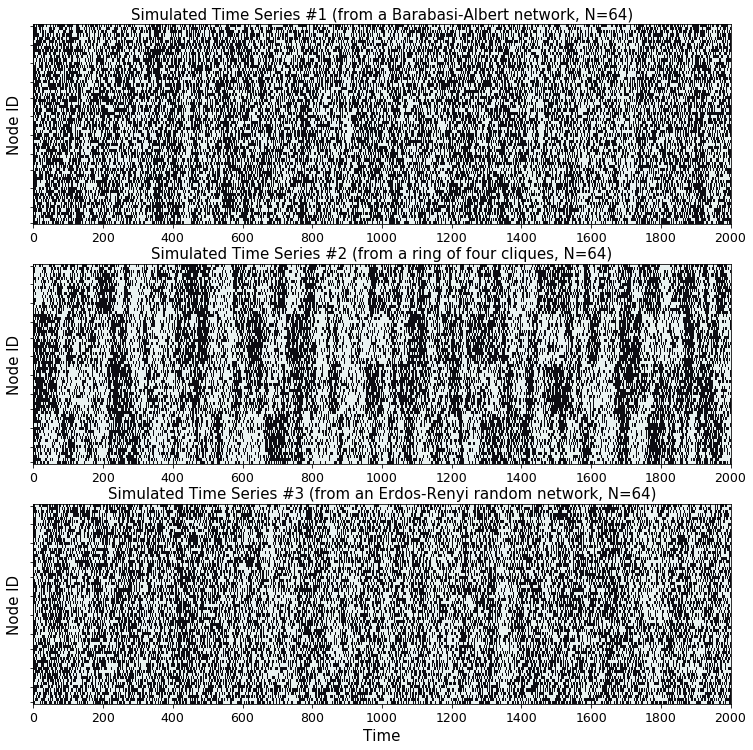

In [6]:
#### plotting parameters ####
width = 2.5
heigh = 2.5
mult  = 5.0 # makes the figure bigger or smaller
filename = ""
fig, (ax1,ax2,ax3) = plt.subplots(3, 1, figsize=(width*mult,heigh*mult))

#### create plot containing each time series #### 
ax1.imshow(ts_1, cmap=netrd_cmap, origin='lower', vmin=-1.15, vmax=1.15, aspect='auto')
ax1.set_ylabel('Node ID', size=3*mult)
xticks = np.linspace(0.0, ts_1.shape[1]-1, 11, dtype=int)
yticks = np.linspace(0.0, ts_1.shape[0]-1, 12, dtype=int)
ax1.set_xticks(xticks)
ax1.set_xticklabels(xticks, fontsize=2.5*mult)
ax1.set_yticks(yticks)
ax1.set_yticklabels([], fontsize=2.5*mult)
ax1.set_title("Simulated Time Series #1 (from a Barabasi-Albert network, N=%i)"%N, fontsize=3*mult)

ax2.imshow(ts_2, cmap=netrd_cmap, origin='lower', vmin=-1.15, vmax=1.15, aspect='auto') 
ax2.set_ylabel('Node ID', size=3*mult)
xticks = np.linspace(0.0, ts_2.shape[1]-1, 11, dtype=int)
yticks = np.linspace(0.0, ts_2.shape[0]-1, 12, dtype=int)
ax2.set_xticks(xticks)
ax2.set_xticklabels(xticks, fontsize=2.5*mult)
ax2.set_yticks(yticks)
ax2.set_yticklabels([], fontsize=2.5*mult)
ax2.set_title("Simulated Time Series #2 (from a ring of four cliques, N=%i)"%N, fontsize=3*mult)

ax3.imshow(ts_3, cmap=netrd_cmap, origin='lower', vmin=-1.15, vmax=1.15, aspect='auto')
ax3.set_ylabel('Node ID', size=3*mult)
ax3.set_xlabel('Time', size=3*mult)
xticks = np.linspace(0.0, ts_3.shape[1]-1, 11, dtype=int)
yticks = np.linspace(0.0, ts_3.shape[0]-1, 12, dtype=int)
ax3.set_xticks(xticks)
ax3.set_xticklabels(xticks, fontsize=2.5*mult)
ax3.set_yticks(yticks)
ax3.set_yticklabels([], fontsize=2.5*mult)
ax3.set_title("Simulated Time Series #3 (from an Erdos-Renyi random network, N=%i)"%N, fontsize=3*mult)

# plt.savefig("../figs/pngs/%s_timeseries.png"%method_id, bbox_inches='tight', dpi=425)
# plt.savefig("../figs/pdfs/%s_timeseries.pdf"%method_id, bbox_inches='tight')
plt.show()

## Reconstruct neworks

In [7]:
####################################
W_1 = free_energy_minimization(ts_1)
W_2 = free_energy_minimization(ts_2)
W_3 = free_energy_minimization(ts_3)
####################################

# at this point, we now have three different network 
# reconstructions, corresponding to our three time series

## Plots and tests

In [8]:
# then, purely for plotting purposes
N1 = W_1.shape[0] 
N2 = W_2.shape[0]
N3 = W_3.shape[0]

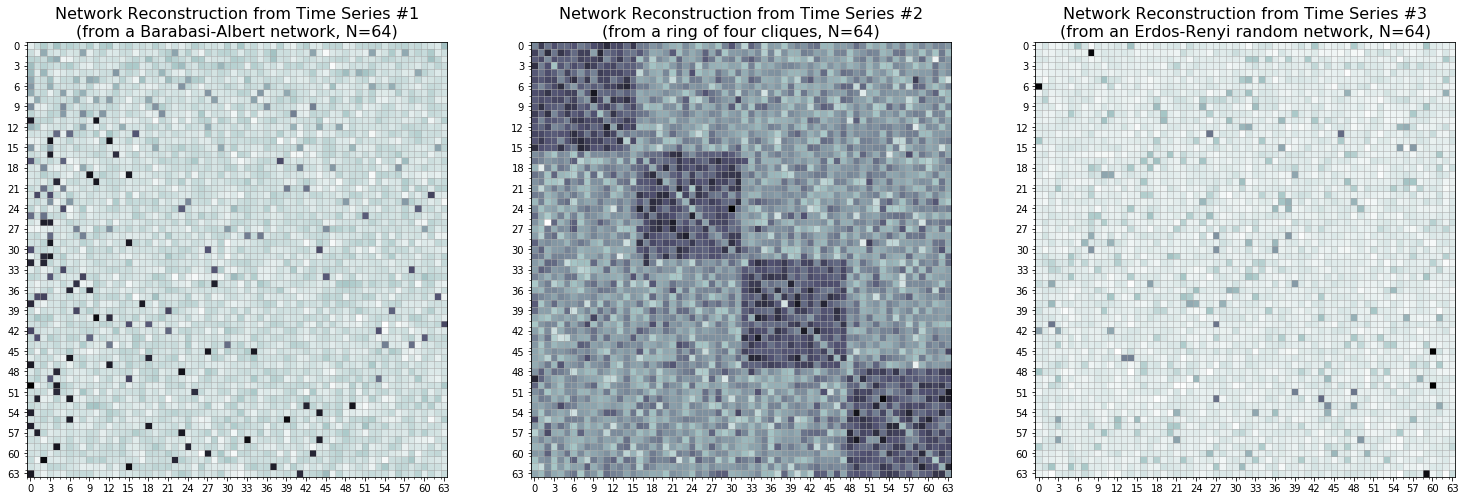

In [9]:
#### plotting parameters ####
width = 3.2
heigh = 1.0
mult  = 8.0
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(width*mult,heigh*mult))

#### plot the weighted adjacency matrix for each ####
ax1.imshow(W_1, aspect='auto', cmap=netrd_cmap)
ax2.imshow(W_2, aspect='auto', cmap=netrd_cmap)
ax3.imshow(W_3, aspect='auto', cmap=netrd_cmap)

ax1.set_xticks(np.arange(0, N1, int(N1*0.05)))
ax1.set_yticks(np.arange(0, N1, int(N1*0.05)))
ax1.set_xticklabels(np.arange(0, N1, int(N1*0.05)))
ax1.set_yticklabels(np.arange(0, N1, int(N1*0.05)))
ax1.set_xticks(np.arange(-.5, N1-0.5, 1), minor=True)
ax1.set_yticks(np.arange(-.5, N1-0.5, 1), minor=True)
ax1.grid(which='minor', color='darkgrey', linestyle='-', linewidth=0.5)
ax1.set_title("Network Reconstruction from Time Series #1\n(from a \
Barabasi-Albert network, N=%i)"%N1, fontsize=2*mult)

ax2.set_xticks(np.arange(0, N2, int(N2*0.05)))
ax2.set_yticks(np.arange(0, N2, int(N2*0.05)))
ax2.set_xticklabels(np.arange(0, N2, int(N2*0.05)))
ax2.set_yticklabels(np.arange(0, N2, int(N2*0.05)))
ax2.set_xticks(np.arange(-.5, N2-0.5, 1), minor=True)
ax2.set_yticks(np.arange(-.5, N2-0.5, 1), minor=True)
ax2.grid(which='minor', color='darkgrey', linestyle='-', linewidth=0.5)
ax2.set_title("Network Reconstruction from Time Series #2\n(from a \
ring of four cliques, N=%i)"%N2, fontsize=2*mult)

ax3.set_xticks(np.arange(0, N3, int(N3*0.05)))
ax3.set_yticks(np.arange(0, N3, int(N3*0.05)))
ax3.set_xticklabels(np.arange(0, N3, int(N3*0.05)))
ax3.set_yticklabels(np.arange(0, N3, int(N3*0.05)))
ax3.set_xticks(np.arange(-.5, N3-0.5, 1), minor=True)
ax3.set_yticks(np.arange(-.5, N3-0.5, 1), minor=True)
ax3.grid(which='minor', color='darkgrey', linestyle='-', linewidth=0.5)
ax3.set_title("Network Reconstruction from Time Series #3\n(from an \
Erdos-Renyi random network, N=%i)"%N3, fontsize=2*mult)


# plt.savefig("../figs/pngs/%s_reconstruction.png"%method_id, bbox_inches='tight', dpi=425)
# plt.savefig("../figs/pdfs/%s_reconstruction.pdf"%method_id, bbox_inches='tight')
plt.show()

## Micro-test: Ground truth from a ring of cliques

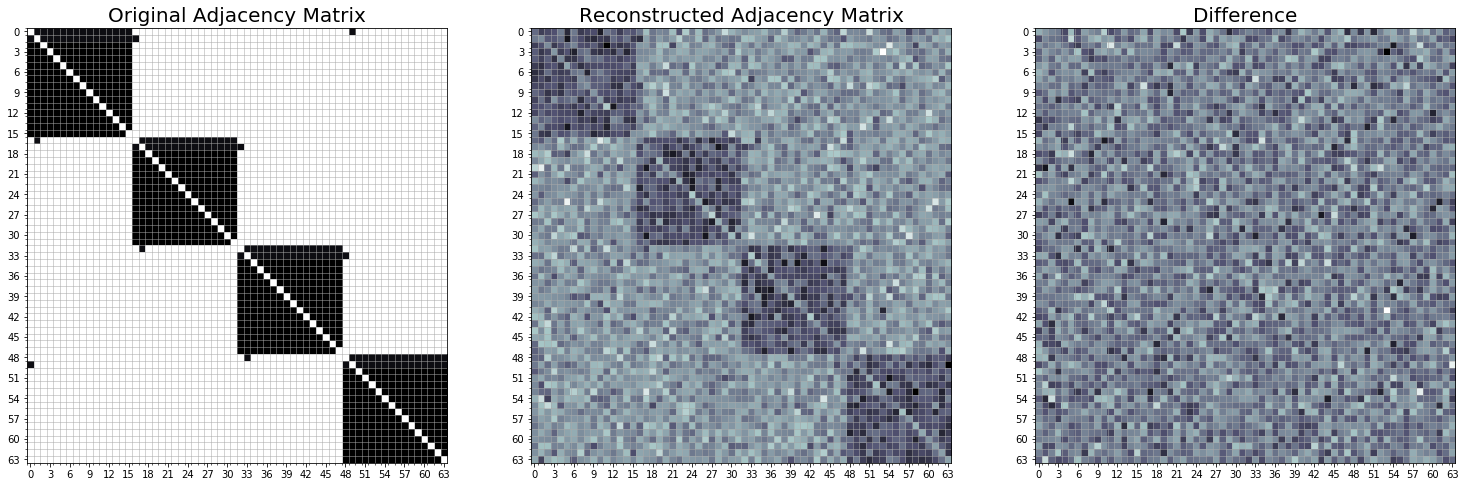

In [10]:
#### plotting parameters ####
width = 3.2
heigh = 1.0
mult  = 8.0
fig, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(width*mult,heigh*mult))

# make a ground truth network
t = 2001
N = 64
nc = 4 # number of cliques
G = nx.ring_of_cliques(nc,int(N/nc))
G = nx.to_directed(G)
w0 = get_Wout_full(G, p0)

# generate time series data
ts = generate_data(w0,t).T
W = free_energy_minimization(ts)


#### plot the original matrix, the reconstructed, and the difference ####
ax0.imshow(w0  , aspect='auto', cmap=netrd_cmap)
ax1.imshow(W   , aspect='auto', cmap=netrd_cmap)
ax2.imshow(w0-W, aspect='auto', cmap=netrd_cmap)

ax0.set_xticks(np.arange(0, N, int(N*0.05)))
ax0.set_yticks(np.arange(0, N, int(N*0.05)))
ax0.set_xticklabels(np.arange(0, N, int(N*0.05)))
ax0.set_yticklabels(np.arange(0, N, int(N*0.05)))
ax0.set_xticks(np.arange(-.5, N-0.5, 1), minor=True)
ax0.set_yticks(np.arange(-.5, N-0.5, 1), minor=True)
ax0.grid(which='minor', color='darkgrey', linestyle='-', linewidth=0.5)

ax1.set_xticks(np.arange(0, N, int(N*0.05)))
ax1.set_yticks(np.arange(0, N, int(N*0.05)))
ax1.set_xticklabels(np.arange(0, N, int(N*0.05)))
ax1.set_yticklabels(np.arange(0, N, int(N*0.05)))
ax1.set_xticks(np.arange(-.5, N-0.5, 1), minor=True)
ax1.set_yticks(np.arange(-.5, N-0.5, 1), minor=True)
ax1.grid(which='minor', color='darkgrey', linestyle='-', linewidth=0.5)

ax2.set_xticks(np.arange(0, N, int(N*0.05)))
ax2.set_yticks(np.arange(0, N, int(N*0.05)))
ax2.set_xticklabels(np.arange(0, N, int(N*0.05)))
ax2.set_yticklabels(np.arange(0, N, int(N*0.05)))
ax2.set_xticks(np.arange(-.5, N-0.5, 1), minor=True)
ax2.set_yticks(np.arange(-.5, N-0.5, 1), minor=True)
ax2.grid(which='minor', color='darkgrey', linestyle='-', linewidth=0.5)

ax0.set_title("Original Adjacency Matrix"     , fontsize=2.5*mult)
ax1.set_title("Reconstructed Adjacency Matrix", fontsize=2.5*mult)
ax2.set_title("Difference"                    , fontsize=2.5*mult)


# plt.savefig("../figs/pngs/%s_groundtruth.png"%method_id, bbox_inches='tight', dpi=425)
# plt.savefig("../figs/pdfs/%s_groundtruth.pdf"%method_id, bbox_inches='tight')
plt.show()

## Rudimentary runtime analysis: spanning time lengths and network sizes

In [ ]:
import datetime as dt

n_iters = 10
n_sizes = 21
n_times = 21

sizes = np.linspace(20,  220,   n_sizes, dtype=int)
times = np.linspace(500, 5500,  n_times, dtype=int)

time_map = np.zeros((n_sizes, n_times))

i = 0
for N in sizes:
    print(dt.datetime.now(), "- Currently testing: %03i node time series"%N)
    j = 0
    for t in times:
        Nt_time = []
        for _ in range(n_iters):
            
            ts_i = simulated_timeseries_from_network(N, t, network_type='BA')
            
            curr = dt.datetime.now().timestamp()      # start the clock
            W_i  = free_energy_minimization(ts_i)     # run the alg
            diff = dt.datetime.now().timestamp()-curr # stop the clock
            
            Nt_time.append(diff)
            
        time_map[i,j] = np.mean(Nt_time)
        j += 1
    i += 1

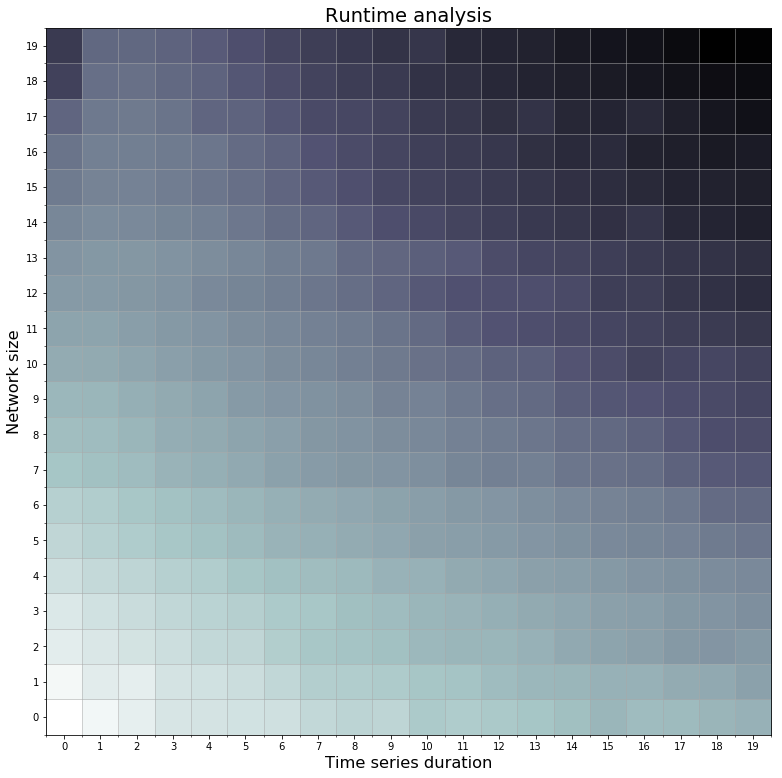

In [69]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
#### plotting parameters ####
width = 2.0
heigh = 2.0
mult  = 6.5
fig, ax0 = plt.subplots(1, 1, figsize=(width*mult,heigh*mult))

ax0.imshow(np.log(time_map)[1:,1:], origin='lower', aspect='auto', cmap=netrd_cmap)

ax0.set_xticks(np.arange(0, n_times-1, int(n_times*0.05)))
ax0.set_yticks(np.arange(0, n_sizes-1, int(n_sizes*0.05)))
ax0.set_xticklabels(np.arange(0, n_times, int(n_times*0.05)))
ax0.set_yticklabels(np.arange(0, n_sizes, int(n_sizes*0.05)))
ax0.set_xticks(np.arange(-.5, n_times-0.5, 1), minor=True)
ax0.set_yticks(np.arange(-.5, n_sizes-0.5, 1), minor=True)
ax0.grid(which='minor', color='darkgrey', linestyle='-', linewidth=0.5)

ax0.set_xlabel("Time series duration", fontsize=2.5*mult)
ax0.set_ylabel("Network size",         fontsize=2.5*mult)
ax0.set_title("Runtime analysis",      fontsize=3.0*mult)

# plt.savefig("../figs/pngs/%s_runtime.png"%method_id, bbox_inches='tight', dpi=425)
# plt.savefig("../figs/pdfs/%s_runtime.pdf"%method_id, bbox_inches='tight')
plt.show()

___________________________